In [1]:
!pip install --upgrade psann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 170.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
from pathlib import Path
import sys as _sys
try:  # noqa: F401
    import psann  # type: ignore
except Exception:  # pragma: no cover
    _sys.path.insert(0, str(Path(__file__).resolve().parents[1] / "src"))
    import psann  # type: ignore

import argparse
import time
from typing import Optional


import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from psann import PSANNRegressor, PredictiveExtrasConfig, portfolio_log_return_reward, make_predictive_extras_trainer_from_estimator
from psann.augmented import PredictiveExtrasTrainer
from psann.metrics import equity_curve, portfolio_metrics

In [2]:
def prices_context_extractor(X_ep: torch.Tensor) -> torch.Tensor:
    return X_ep

def series_reward(tr, X_prices):
    alloc, _ = tr.infer_series(X_prices)
    alloc_b = torch.from_numpy(alloc).unsqueeze(0).float()
    prices_b = torch.from_numpy(X_prices).unsqueeze(0).float()
    with torch.no_grad():
        r = portfolio_log_return_reward(alloc_b, prices_b, trans_cost=cfg.trans_cost)
    return float(r.item())

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
#df = pd.read_parquet("/content/drive/MyDrive/PSANN Crypto/market_data/FiveMinSOL.parquet").sort_index().dropna().reset_index()

Mounted at /content/drive


In [4]:
tickers = ['ADA','BTC','CRO','ETH','SOL','XRP']
df = pd.DataFrame()

iter = 1
for ticker in tickers:
  if ticker == tickers[0]:
    df = pd.read_parquet(f"/content/drive/MyDrive/PSANN Crypto/market_data/{ticker}.parquet").sort_index().dropna().reset_index()[['timestamp','close']].rename(columns = {'close':f'close_{ticker}'})
  else:
    sub_df = pd.read_parquet(f"/content/drive/MyDrive/PSANN Crypto/market_data/{ticker}.parquet").sort_index().dropna().reset_index().rename(columns = {'close':f'close_{ticker}'})
    sub_df['Ticker'] = ticker
    sub_df.reset_index(inplace=True)
    df = df.merge(sub_df[['timestamp',f'close_{ticker}']], on='timestamp')

In [5]:
df['timestamp'] = pd.to_numeric(df['timestamp'])
df['close_USD'] = 1

In [6]:
df['ts'] = pd.to_datetime(df['timestamp'], unit='ns', utc=True)

# 2) Index by time
df = df.set_index('ts').sort_index()

# 3) Pick how you want to aggregate.
# For “close_*” columns, hourly close is usually the LAST 5-min close in each hour:
close_cols = [c for c in df.columns if c.startswith('close_')]
hourly_close = (
    df[close_cols]
    .resample('H')            # hourly bins
    .last()                   # last value in each hour
)

# If you prefer hourly mean instead:
hourly_mean = df[close_cols].resample('H').mean()

# If there can be missing 5-min rows and you want continuous hours:
hourly_close = hourly_close.asfreq('H').ffill()
hourly_close.reset_index(inplace=True)
hourly_close['ts'] = hourly_close['ts'].astype(int)

df = hourly_close.copy()

/tmp/ipython-input-470772549.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')            # hourly bins
/tmp/ipython-input-470772549.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_mean = df[close_cols].resample('H').mean()
/tmp/ipython-input-470772549.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_close = hourly_close.asfreq('H').ffill()


In [7]:
df.drop(columns = 'close_USD', inplace=True)

In [8]:
df_final = df.copy()#.tail(50000)
split = int(.9 * len(df_final))
split_val = int(.2 * len(df_final))
train = df_final[:split]
val = train[:split_val]
train = train[split_val:]
test = df_final[split:]

In [9]:
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

In [10]:
print(train.shape)
print(val.shape)
print(test.shape)

(18298, 7)
(5227, 7)
(2614, 7)


In [13]:
hidden_size = 128
hidden_layers = 2
extras = 8
epochs = 500
episode_length = 48
trans_cost = 0#1e-3

psann = PSANNRegressor(random_state=0, hidden_layers=hidden_layers, hidden_width=hidden_size, activation_type="psann", extras=0, epochs=epochs, lr=1e-3, scaler='standard')
psann.fit(train, y=None, hisso=True, hisso_window=episode_length, verbose=1, noisy=.005, hisso_trans_cost=float(trans_cost))

[PredictiveExtras] epoch 1/500 reward=-0.006216
[PredictiveExtras] epoch 2/500 reward=-0.001556
[PredictiveExtras] epoch 3/500 reward=-0.005387
[PredictiveExtras] epoch 4/500 reward=-0.002639
[PredictiveExtras] epoch 5/500 reward=0.000810
[PredictiveExtras] epoch 6/500 reward=0.007080
[PredictiveExtras] epoch 7/500 reward=0.002838
[PredictiveExtras] epoch 8/500 reward=0.004701
[PredictiveExtras] epoch 9/500 reward=0.011815
[PredictiveExtras] epoch 10/500 reward=-0.004913
[PredictiveExtras] epoch 11/500 reward=0.004746
[PredictiveExtras] epoch 12/500 reward=0.011167
[PredictiveExtras] epoch 13/500 reward=0.011399
[PredictiveExtras] epoch 14/500 reward=0.005862
[PredictiveExtras] epoch 15/500 reward=-0.001837
[PredictiveExtras] epoch 16/500 reward=0.007580
[PredictiveExtras] epoch 17/500 reward=0.004502
[PredictiveExtras] epoch 18/500 reward=0.001468
[PredictiveExtras] epoch 19/500 reward=0.004677
[PredictiveExtras] epoch 20/500 reward=0.002635
[PredictiveExtras] epoch 21/500 reward=-0.0

PSANNRegressor(activation={}, epochs=500, hidden_layers=32, hidden_width=128,
               lr=1e-05, scaler='standard')

In [14]:
psann_extras = PSANNRegressor(random_state=0, hidden_layers=hidden_layers, hidden_width=hidden_size, activation_type="psann", extras=extras, epochs=epochs, lr=1e-3, scaler='standard')
psann_extras.fit(train, y=None, hisso=True, hisso_window=episode_length, verbose=1, noisy=.005, hisso_trans_cost=float(trans_cost))

[PredictiveExtras] epoch 1/500 reward=-0.011328
[PredictiveExtras] epoch 2/500 reward=-0.008938
[PredictiveExtras] epoch 3/500 reward=0.006744
[PredictiveExtras] epoch 4/500 reward=0.012769
[PredictiveExtras] epoch 5/500 reward=0.001094
[PredictiveExtras] epoch 6/500 reward=-0.000503
[PredictiveExtras] epoch 7/500 reward=0.007939
[PredictiveExtras] epoch 8/500 reward=0.015349
[PredictiveExtras] epoch 9/500 reward=-0.000820
[PredictiveExtras] epoch 10/500 reward=-0.005888
[PredictiveExtras] epoch 11/500 reward=0.002475
[PredictiveExtras] epoch 12/500 reward=0.008043
[PredictiveExtras] epoch 13/500 reward=-0.002913
[PredictiveExtras] epoch 14/500 reward=-0.009351
[PredictiveExtras] epoch 15/500 reward=-0.006966
[PredictiveExtras] epoch 16/500 reward=0.001236
[PredictiveExtras] epoch 17/500 reward=0.002386
[PredictiveExtras] epoch 18/500 reward=0.008795
[PredictiveExtras] epoch 19/500 reward=0.010759
[PredictiveExtras] epoch 20/500 reward=0.014219
[PredictiveExtras] epoch 21/500 reward=0.

PSANNRegressor(activation={}, epochs=500, extras=8, hidden_layers=32,
               hidden_width=128, lr=1e-05, scaler='standard')

In [46]:
# psann.save('psann_model.pt')

In [15]:
alloc_psann_test, _ = psann.hisso_infer_series(test)

In [16]:
alloc_psann_extras_test, __ = psann_extras.hisso_infer_series(test)

In [17]:
M = test.shape[1]

A_bh = np.full((len(test), M), 1.0 / M, dtype=np.float32)

# Equity curves (start at 1.0)
c_bh = equity_curve(A_bh, test, trans_cost=float(trans_cost))
c_ps = equity_curve(alloc_psann_test, test, trans_cost=float(trans_cost))
c_ps_extras = equity_curve(alloc_psann_extras_test, test, trans_cost=float(trans_cost))

# Print metrics
print("PSANN: ",portfolio_metrics(alloc_psann_test, test, trans_cost=float(trans_cost)))
print("PSANN Extras: ",portfolio_metrics(alloc_psann_extras_test, test, trans_cost=float(trans_cost)))
print("B&H :", portfolio_metrics(A_bh, test, trans_cost=float(trans_cost)))

PSANN:  {'cum_return': 0.08157819770130037, 'log_return': 0.07842126865267765, 'sharpe': 0.007747530119336553, 'max_drawdown': -0.32575463692982254, 'turnover': 0.0}
PSANN Extras:  {'cum_return': 0.08171995282373357, 'log_return': 0.07855232328571718, 'sharpe': 0.007754934438292619, 'max_drawdown': -0.3253747061302443, 'turnover': 0.0}
B&H : {'cum_return': 0.0820190797202589, 'log_return': 0.07882881402136682, 'sharpe': 0.007770367218496437, 'max_drawdown': -0.32487416419270576, 'turnover': 0.0}


In [18]:
#psann = PSANNRegressor.load('psann_model.pt')

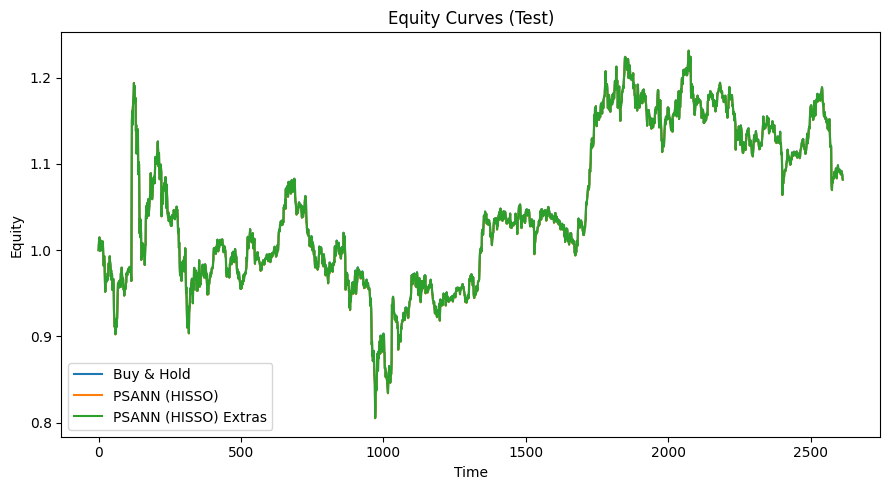

In [19]:
import matplotlib.pyplot as plt  # type: ignore
plt.figure(figsize=(9, 5))
plt.plot(c_bh, label="Buy & Hold")
plt.plot(c_ps, label="PSANN (HISSO)")
plt.plot(c_ps_extras, label="PSANN (HISSO) Extras")
plt.title("Equity Curves (Test)")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.legend()
plt.tight_layout()